In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib. patches import Arc
import matplotlib.pyplot as plt
import matplotlib.cbook as cbook
from matplotlib.ticker import FormatStrFormatter
from matplotlib_scalebar.scalebar import ScaleBar
import re
import pandas as pd
%matplotlib inline 
import numpy as np
import math
import pims
import cv2
from scipy import interpolate
from scipy.signal import savgol_filter
import skimage.filters as sk_fil
import imutils
from skimage.transform import rotate
import sys
import PIL
from pathlib import Path
sys.path.insert(0, '/Users/lfsmbn/orkun/projects/ongoing/GBMF_motility/')
sys.path.insert(0, '/Users/lfsmbn/orkun/projects/ongoing/GBMF_motility/Jerko_files/Manuscript_Code/')
import myAnalyses.lowmag_analysis_OSS as dio
import Filament_Analysis.various_funcs as var

In [2]:
#########
## get septa trajectory data from TIRF image analysis
#########

path = Path(r'/Users/lfsmbn/orkun/projects/ongoing/GBMF_motility/Jerko_files/Manuscript_Code/Jupyter_Notebooks/Analysis/TIRF')

folders = [item for item in path.iterdir() if item.is_dir()]
dataframes=[]
for folder in folders:
    for item in folder.iterdir():
        if re.search('septae', item.name) is not None:
            df = pd.read_csv(item)
            df['experiment'] = item.parent.name
            df.drop(columns=['Unnamed: 0'], inplace=True)
            dataframes.append(df)

combined_df_Septae = pd.concat(dataframes, ignore_index=True)      #dataframe containing all of the data in the TIRF folder
unique_experiments_Septae = pd.unique(combined_df_Septae['experiment']) #returns list of unique experiment names
len(combined_df_Septae), unique_experiments_Septae,len(unique_experiments_Septae)

(205582,
 array(['22_Feb_23_TIRF473-14', '22-Feb-23_tirf-5', '21_Feb_23_TIRF473-2',
        '21_Feb_23_TIRF473-3', '22-Feb-23_tirf-7', '22_Feb_23_TIRF473-17',
        '21_Feb_23_TIRF473-6', '29_Nov_22_TIRF473', '21_Feb_23_TIRF473-8',
        '10_Nov_23_TIRF473-7', '21_Feb_23_TIRF473-7'], dtype=object),
 11)

In [4]:
#########
## get frames of associated TIRF movie
#########

experimentOfChoice = 6     #this is 21Feb23-473-6 in both septae and blob data

pathA = r'/Users/lfsmbn/orkun/projects/ongoing/GBMF_motility/Jerko_files/Manuscript_Code/movies/21-Feb-23_TIRF473-6-f510_level562_window413-2.tif'
pathB = r'/Users/lfsmbn/orkun/projects/ongoing/GBMF_motility/Jerko_files/Manuscript_Code/movies/21-Feb-23_TIRF473-6-f595_level562_window413-2.tif'

framesA = pims.open(pathA)
framesB = pims.open(pathB)

base_file_septae = unique_experiments_Septae[experimentOfChoice]

#specify movie parameters
um_per_px = 0.117 #um
dt = 33/1000 #1/33 #sec

base_file_septae

'21_Feb_23_TIRF473-6'

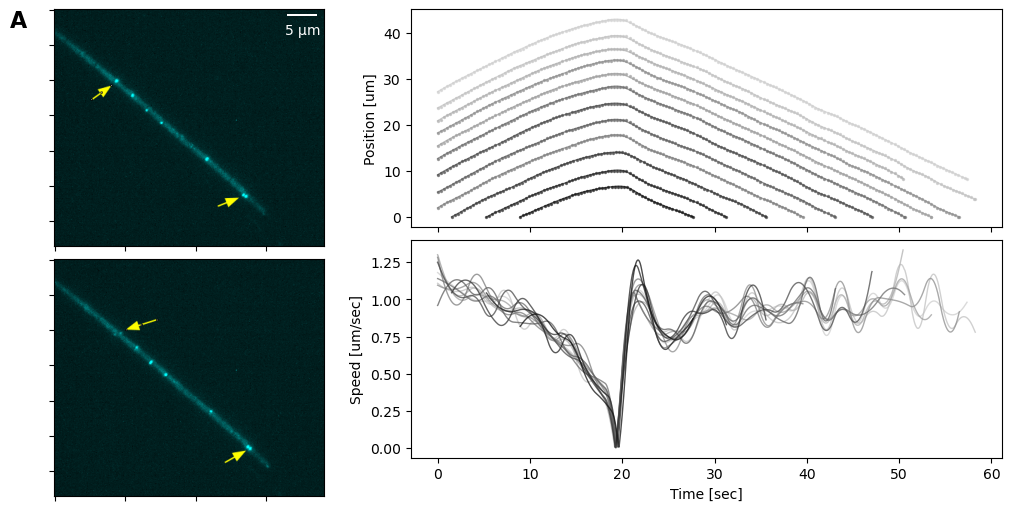

In [6]:
###########
#PLOTTING - WHAT A FANCY PLOT!
###########

#define output path and save file name
path_out = r'/Users/lfsmbn/orkun/projects/ongoing/GBMF_motility/'
saveFile_FigS9 = path_out+base_file_septae+'_S9.png'
saveFile1_FigS9 = path_out+base_file_septae+'_S9.tif'

#initiate a multi-plot with 2 columns
fig = plt.figure(layout='constrained', figsize=(10, 5))
subfigs = fig.subfigures(1, 2,width_ratios=[1,2])


###########
#PART A - images 
###########

#create an axis comprising a 2 rows 1 column subfigure
axsLeft = subfigs[0].subplots(2, 1, gridspec_kw={'height_ratios': [1,1]}) #sharex=True,sharey=True
axsLeft[0].text(-0.1, 1, 'A', transform=axsLeft[0].transAxes,
      fontsize=16, fontweight='bold', va='top', ha='right')

#decide time points for frames to show
t1=1200
t2=2000

#show images
axsLeft[0].imshow(framesA[0],cmap='gray')

#limX1, limX2 = 200, 400
#limY1, limY2 = 300, 450 #200,500
#axsLeft[0].set_xlim([limX1, limX2])
#axsLeft[0].set_ylim([limY1, limY2])

#add scale bar
scalebar = ScaleBar(um_per_px*10**-6,location="upper right",color='w',frameon=False) # 1 pixel = 0.2 meter
axsLeft[0].add_artist(scalebar)

#show second image
axsLeft[1].imshow(framesB[0],cmap='gray')

#axsLeft[1].set_xlim([limX1, limX2])
#axsLeft[1].set_ylim([limY1, limY2])

plt.setp(axsLeft[0].get_xticklabels(), visible=False)
plt.setp(axsLeft[0].get_yticklabels(), visible=False)
plt.setp(axsLeft[1].get_xticklabels(), visible=False)
plt.setp(axsLeft[1].get_yticklabels(), visible=False)



###################################
#position and speed analysis for septae
###################################


#key PARAMETERS to set
spline_k = 3                    #what order should we use when fitting the spling
spacing = 1                     #spacing to use for the gradient function used for speed calc
speedLimit = 0.2               #what speed limit we should use to decide "dwell" (i.e. reversal)
sparsity = 50 
sparsity2 = 10
sparsity3 = 10

#for supp figure use 21Feb-473-8 and 21Feb-473-6
#for main figure use 21Feb-473-6
experiment_septae = unique_experiments_Septae[experimentOfChoice] #21Feb23-473-7 

#gather data from specified experiment and for all particles found there
dataForExperiment = combined_df_Septae[combined_df_Septae['experiment'] == experiment_septae]
unique_particles2 = pd.unique(dataForExperiment.loc[dataForExperiment['experiment']==experiment_septae, 'particle'])

#colors = plt.cm.inferno(np.linspace(0.3,1,len(unique_particles2)+1))
colors = plt.cm.Greys(np.linspace(0.3,1,len(unique_particles2)+1))

#axsLeftBot = subfigs[1,0].subplots(2, 1,sharex=True)
axsLeftBot = subfigs[1].subplots(2, 1)
#fig, ax = plt.subplots(2,1, figsize = (10,6), dpi=300)
#axsLeftBot[0,0].text(-0.05, 1.1, 'B', transform=axsLeftBot[0,0].transAxes,
     # fontsize=16, fontweight='bold', va='top', ha='right')

#ins = axsLeftBot[0].inset_axes([0.77,0.65,0.2,0.3])
t1=320
t2=800
for k,x in enumerate(unique_particles2):
    sub_df = dataForExperiment.loc[(dataForExperiment['particle'] == x)]
    time_axis = sub_df['frame'].values #frame ids
    pos_axis = um_per_px*sub_df['distance'].values #um
 
    frame_ids = np.arange(0, len(pos_axis),1)           #create a x-axis array based on frames 
    frame_ids_sparse = np.arange(0, len(pos_axis),sparsity)      #create a sparse x-axis
    frame_ids_sparse2 = np.arange(0, len(pos_axis),sparsity2)      #create a sparse x-axis
    if frame_ids_sparse[-1] != len(pos_axis)-1: frame_ids_sparse = np.append(frame_ids_sparse,len(pos_axis)-1)  #make sure last frame id is included in the sparse set
    if frame_ids_sparse2[-1] != len(pos_axis)-1: frame_ids_sparse2 = np.append(frame_ids_sparse2,len(pos_axis)-1)  #make sure last frame id is included in the sparse set


    #remove indices with nan values from sparse used for centre spline
    nanIndices = np.where(np.isnan(pos_axis[frame_ids_sparse])) #find any nan values in the position data, the frame id for which is included in the sparse set
    frame_ids_sparse_C = np.delete(frame_ids_sparse,nanIndices)           #get rid of those frame ids from sparse set.

    #spline fitting
    splineC_dist = interpolate.splrep(frame_ids_sparse_C,pos_axis[frame_ids_sparse_C],s=0, k=spline_k) #spline fit dist using data points from frames in the sparse set
    centre_dist_fitted = interpolate.splev(frame_ids, splineC_dist) #use spline to get smoothed curve at all frames for dist

    #speed from fitted dist-coordinate
    speed = np.abs(np.gradient(centre_dist_fitted,spacing)/dt)

    #get sparse time axis and normalised distance for inset
    time_axis_inset = time_axis[np.where((time_axis>t1) & (time_axis<t2))]
    frame_ids_sparse3 = np.arange(0, len(time_axis_inset),sparsity3)      #create a sparse x-axis
    if frame_ids_sparse3[-1] != len(time_axis_inset)-1: frame_ids_sparse3 = np.append(frame_ids_sparse3,len(time_axis_inset)-1)  #make sure last frame id is included in the sparse set
    #pos_axis_partial = pos_axis[np.where((time_axis>t1) & (time_axis<t2))]
    pos_axis_partial = pos_axis[np.where((time_axis>t1) & (time_axis<t2))] 
    distTravelled_norm = (pos_axis_partial-min(pos_axis_partial))/(max(pos_axis_partial)-min(pos_axis_partial))
 
    #plot
    #ax[0].scatter(time_axis[frame_ids_sparse2]*dt, pos_axis[frame_ids_sparse2],marker='o', s=2,color = colors[k], alpha=0.6,label = f'Particle {x}')
    #ax[0].plot(time_axis*dt, centre_dist_fitted,linewidth=1,color = colors[k], alpha=0.7,label = f'Particle {x}')
    axsLeftBot[0].scatter(time_axis[frame_ids_sparse2]*dt, pos_axis[frame_ids_sparse2],marker='o', s=2,color = colors[k], alpha=0.6,label = f'Particle {x}')
    axsLeftBot[0].plot(time_axis*dt, centre_dist_fitted,linewidth=1,color = colors[k], alpha=0.7,label = f'Particle {x}')
    #ins.scatter(time_axis_inset[frame_ids_sparse3]*dt, distTravelled_norm[frame_ids_sparse3], marker='o', s=0.5, color = colors[k], alpha=0.3,label = f'Particle {x}')
    #ax[1].plot(time_axis*dt, speed, linewidth=1,color = colors[k], alpha=0.75, label = f'Particle {x}')
    axsLeftBot[1].plot(time_axis*dt, speed, linewidth=1,color = colors[k], alpha=0.75, label = f'Particle {x}')

axsLeftBot[0].set_ylabel('Position [um]')
#axsLeftBot[0].set_xlabel('Time [sec]')
#ins.set_ylabel('Dist.')
#ins.set_xlabel('Time [sec]')
axsLeftBot[1].set_ylabel('Speed [um/sec]')
axsLeftBot[1].set_xlabel('Time [sec]')

axsLeftBot[0].get_shared_x_axes().join(axsLeftBot[0], axsLeftBot[1])
axsLeftBot[0].set_xticklabels([])

len(unique_particles2), len(time_axis)


fig.savefig(saveFile_FigS9)
fig.savefig(saveFile1_FigS9)
plt.show()
plt.close(fig)




In [78]:
time_axis_inset*dt

array([ 9.108,  9.141,  9.174,  9.207,  9.24 ,  9.273,  9.306,  9.339,
        9.372,  9.405,  9.438,  9.471,  9.504,  9.537,  9.57 ,  9.603,
        9.636,  9.669,  9.702,  9.735,  9.768,  9.801,  9.834,  9.867,
        9.9  ,  9.933,  9.966,  9.999, 10.032, 10.065, 10.098, 10.131,
       10.164, 10.197, 10.23 , 10.263, 10.296, 10.329, 10.362, 10.395,
       10.428, 10.461, 10.494, 10.527, 10.56 , 10.593, 10.626, 10.659])